In [1]:
# import modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ordinary least squares
from statsmodels.formula.api import ols
from statsmodels.stats.weightstats import ztest

plt.style.use('seaborn-colorblind')

# special Jupyter Notebook command to prepare the notebook for matplotlib and other libraries
%matplotlib inline 

# Setup Pandas
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

# Setup Seaborn
sns.set_style("darkgrid")
sns.set_context("notebook")

In [2]:
# read cleaned data file
earnings = pd.read_csv('earnings.csv', index_col=False)
earnings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152544 entries, 0 to 152543
Data columns (total 15 columns):
name           152544 non-null object
department     152544 non-null object
title          152544 non-null object
regular        152544 non-null float64
retro          152544 non-null float64
other          152544 non-null float64
overtime       152544 non-null float64
injured        152544 non-null float64
detail         152544 non-null float64
quinn          152544 non-null float64
total          152544 non-null float64
zip            152544 non-null object
year           152544 non-null int64
dept_clean     152544 non-null object
title_clean    152544 non-null object
dtypes: float64(8), int64(1), object(6)
memory usage: 17.5+ MB


# 1. Are police officers and fire fighters paid the same?

We'll look at the earnings data over all years to see how the pay for police officers and fire fighters is changing.

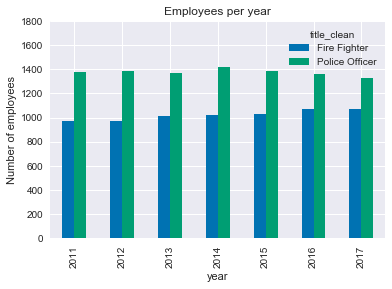

In [3]:
""" police officers and fire fighters

The data will be limited to police officers and fire fighters who received at least $50,000 
regular earnings. This is an attempt to remove new hires, retirees, part timers and other
non-standard employees.

"""

pf = earnings[(earnings['title_clean'].isin(['Police Officer', 'Fire Fighter'])) & (earnings['regular'] > 50000)]
pf_pt = pf.pivot_table(columns='title_clean', index='year', values='name', aggfunc='count')

pf_pt.plot.bar()
plt.title('Employees per year')
plt.ylim(0, 1800)
plt.ylabel('Number of employees')
plt.show()

There are roughly 1000 fire fighters and 1400 police officers working for the city of Boston. Over the years 2011 through 2017 we can observe a slight decrease in the number of police officers starting in 2014. Fire fighters, on the other hand, have gradually grown in numbers since 2012. 

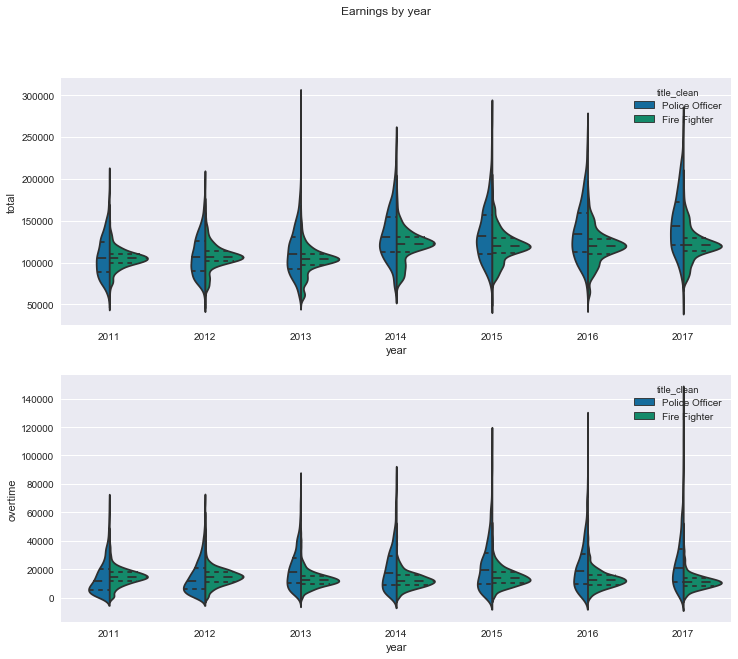

In [4]:
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(12,10))
fig.suptitle('Earnings by year')
sns.violinplot(x='year', y='total', hue='title_clean', data=pf, split=True, ax=ax1, inner='quartile')
sns.violinplot(x='year', y='overtime', hue='title_clean', data=pf, split=True, ax=ax2, inner='quartile')
plt.show()

The median total earnings for police officers and fire fighters is around \$100,000 to \$150,000, steadily growing over the years. Interestingly, the median total earnings for police officers has grown significantly more than for fire fighters. Similarly, the overtime pay is approximately \$15,000 a year for both groups in 2011. Starting in 2013, overtime pay for police officers is steadily increasing to above \$20,000 in 2017, but there is no clear change in median overtime pay for fire fighters.

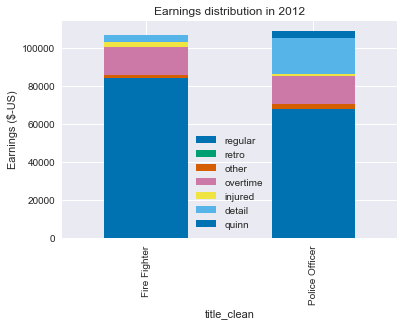

In [5]:
pf2012 = pf[pf.year == 2012]
ax = pf2012.groupby('title_clean').agg(np.mean).drop(['total','year'], axis=1).plot.bar(stacked=True, title='Earnings distribution in 2012')
ax.set_ylabel('Earnings ($-US)')
plt.show()
 
# ax = pf.groupby(['year', 'title_clean']).agg(np.mean).drop(['total'], axis=1).plot.bar(stacked=True, title='Earnings distribution')
# ax.set_ylabel('Earnings ($-US)')
# plt.show()

The earnings distribution for 2012 shows roughly equal total mean earnings, however fire fighters receive higher regular pay. Police officers make up the difference with "detail" and "quinn" earnings.

### Are police officers and fire fighters paid the same?

Let's extract the total and regular earnings for police officers and fire fighters for each year. The null hypothesis is no difference in earnings for both job titles and a significance (p) of 0.05, or a less than 5% chance that a difference is found when in fact there is none.

In [6]:
years = sorted(set(pf.year))
z_year = []
p_year = []
for year in years:
    po = pf['total'][(pf.year == year) & (pf.title_clean == 'Police Officer')]
    ff = pf['total'][(pf.year == year) & (pf.title_clean == 'Fire Fighter')]
    z, p = ztest(po, ff)
    z_year.append(z)
    p_year.append(p)
print('Year:', 'z-stat:', 'p:')
for p in zip(years, z_year, p_year):
    print(p[0], '{:4.2f}'.format(p[1]),'{: .2g}'.format(p[2]))

Year: z-stat: p:
2011 3.10  0.002
2012 2.13  0.033
2013 11.23  3e-29
2014 12.77  2.3e-37
2015 13.62  2.9e-42
2016 16.27  1.6e-59
2017 22.01  2.2e-107


The results show that p is less than 0.05 for all years, indicating we should reject the null hypothesis. As can be seen from the violin plot above, the differences in 2011 and 2012 are very small and the corresponding p values are the highest from this analysis. Over the following years the difference in total earnings is becoming more and more statistically significant.

### Now let's look at overtime pay:

In [7]:
t_year = []
p_year = []
for year in years:
    po = pf['overtime'][(pf.year == year) & (pf.title_clean == 'Police Officer')]
    ff = pf['overtime'][(pf.year == year) & (pf.title_clean == 'Fire Fighter')]
    z, p = ztest(po, ff)
    z_year.append(z)
    p_year.append(p)
print('Year:', 'z-stat:', 'p:')
for p in zip(years, z_year, p_year):
    print(p[0], '{:4.2f}'.format(p[1]),'{: .2g}'.format(p[2]))

Year: z-stat: p:
2011 3.10  0.27
2012 2.13  0.74
2013 11.23  4.2e-63
2014 12.77  2.5e-54
2015 13.62  5.5e-46
2016 16.27  1.5e-62
2017 22.01  2.3e-106


For the years 2011 and 2012 we fail to reject the null hypothesis and claim there is no statistically significant difference in overtime pay for both groups. After 2013 the difference becomes significant.

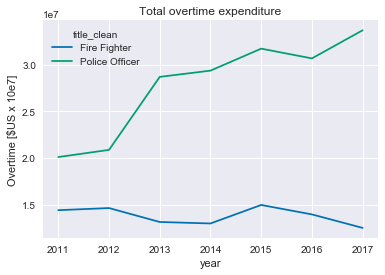

In [8]:
# fire fighters vs. police officers: Overtime

ff = earnings[(earnings['title_clean'] == 'Police Officer')\
                             | (earnings['title_clean'] == 'Fire Fighter')]

ff_pt = pd.pivot_table(ff, values='overtime', index='year', columns='title_clean', aggfunc=np.sum)
ff_pt.plot()
plt.title('Total overtime expenditure')
plt.ylabel('Overtime [$US x 10e7]')
plt.show()

If overtime for police officers were frozen at 2011 levels, the city would save approximately \$13 million in 2017.

# 2. Does injured pay replace regular earnings?

2017 number of employees: 1278


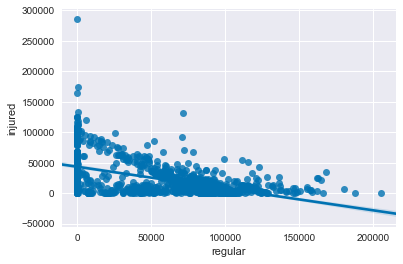

In [9]:
""" 
All 2017 data with at least $1 injured pay
"""
injured = earnings[(earnings.injured > 1) & (earnings.year == 2017)]

print('2017 number of employees:', injured.shape[0])
sns.regplot(x='regular', y='injured', data=injured)
plt.show()

Some adjustments to the data are necessary since the database captures "earnings" and not salaries. The data is arbitrarily limited to combined injured pay and regular earnings of at least \$50,000. Additionally we are interested in long-term injured pay of at least \$5,000 for the year 2017.

2017 number of employees: 608


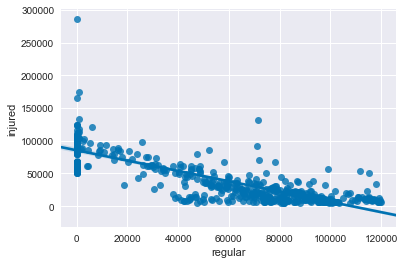

In [10]:
""" 
dataset focused on 'normal' income levels with both regular and injured earnings types
"""
injured = earnings[((earnings.injured + earnings.regular) > 50000) \
                   & (earnings.regular < 120000) \
                   & (earnings.injured > 5000) \
                   & (earnings.year == 2017)]

print('2017 number of employees:', injured.shape[0])
sns.regplot(x='regular', y='injured', data=injured)
plt.show()

In [11]:
m = ols('regular ~ injured', injured).fit()
print(m.summary())

                            OLS Regression Results                            
Dep. Variable:                regular   R-squared:                       0.712
Model:                            OLS   Adj. R-squared:                  0.711
Method:                 Least Squares   F-statistic:                     1495.
Date:                Sat, 28 Apr 2018   Prob (F-statistic):          9.10e-166
Time:                        12:04:16   Log-Likelihood:                -6898.6
No. Observations:                 608   AIC:                         1.380e+04
Df Residuals:                     606   BIC:                         1.381e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   9.476e+04   1203.494     78.736      0.0

Once the earnings data is modified to correct for part time employment and minor "injuries", i.e. minor injured pay (less than \$5,000), the data shows some correlation which could be explained by injured pay replacing regular earnings. According to the OLS model, for every dollar lost in regular earnings, the employee receives about 90 cents injured pay. The correlation is rather weak. Only ~66% of the variance is explained by the model.

## 3. Can we quantify geographic wealth segregation?

Using Zillow's median home values by zip code, let's compare the median earnings and take a look at the geographic distribution of income levels.

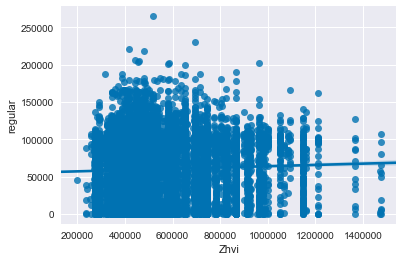

In [12]:
"""
Zillow provides a home value estimator by zip code called the "Zhvi" or Zillow home value index:
*A smoothed, seasonally adjusted measure of the median estimated home value across a given region and housing type.*

https://www.zillow.com/research/data/

The data used is the zip code data set from April 2018.
"RegionName" = zip code
"""
# Zillow home values:
home_values = pd.read_csv('Zip_Zhvi_Summary_AllHomes.csv', dtype={'RegionName': object})
home_values = home_values[(home_values.Metro == 'Boston')][['RegionName', 'Zhvi']]

# regular earnings by zip code data frame:
e_by_zip = earnings[(earnings.zip.isin(home_values.RegionName)) & (earnings.year == 2017)]\
                .merge(home_values, how='left', left_on='zip', right_on='RegionName')[['regular', 'zip', 'Zhvi']]
    
# regression plot of regular earnings by home values
sns.regplot(x='Zhvi', y='regular', data=e_by_zip)
plt.show()


In [13]:
reg = ols('Zhvi ~ regular',e_by_zip).fit()
print(reg.summary())


                            OLS Regression Results                            
Dep. Variable:                   Zhvi   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     24.21
Date:                Sat, 28 Apr 2018   Prob (F-statistic):           8.69e-07
Time:                        12:04:17   Log-Likelihood:            -2.8528e+05
No. Observations:               21407   AIC:                         5.706e+05
Df Residuals:                   21405   BIC:                         5.706e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    5.16e+05   1886.970    273.477      0.0

The OLS model suggests that there is a very modest correlation between regular earnings of an employee and the Zillow home value index of the employee's home zip code. For every \$10,000 in regular earnings, the Zillow home value index will increase by approximately \$1311, on average for all employees and zip codes. In practice there is hardly any value in such a weak correlation. There are many factors that mitigate wealth segregation such as family ties, personal history and subsidized housing.

Having said that, there are definitely some extreme cases that can be highlighted:

   neighborhood    Zhvi
5    Roslindale  518379
12       Milton  653795
84      Roxbury  385426


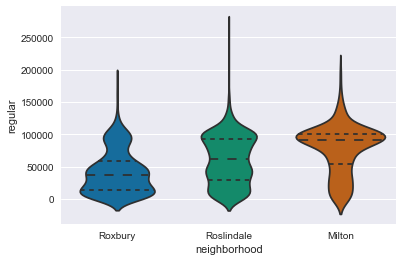

In [14]:
# example neighborhoods:
neighborhoods = pd.DataFrame.from_dict({'02186': 'Milton', '02131': 'Roslindale', '02121': 'Roxbury'}, orient='index')\
                            .reset_index()
neighborhoods.columns = ['nzip', 'neighborhood']

# add neighborhood names to data frame:
e_by_zip = e_by_zip.merge(neighborhoods, how='left', left_on='zip', right_on='nzip')                          
seg = e_by_zip[(e_by_zip.zip.isin(neighborhoods.nzip))]
print(seg[['neighborhood', 'Zhvi']].drop_duplicates())

# plot regular income violin plots for exampmle neighborhoods:
sns.violinplot(x='neighborhood', y='regular', data=seg, order=['Roxbury', 'Roslindale', 'Milton'], inner='quartile')
plt.show()

The shape of the violinplots above should be no surprise to local Bostonians. Roxbury is as undesirable as Milton is desirable a neighborhood. The plots show predominantly low income employees in Roxbury with only a few employees earning more than \$100,000 in 2017. The median regular earnings are less than \$50,000. Milton's employees earn a median of close to \$100,000 and a first quartile already above Roxbury's median. Roslindale is a diverse neighborhood with a near cylindrical-shaped violin plot.